# Model construct Notebook (Colab)

Idée : Pixelbyte: Mamba Catch Unified Multimodal Generation / One unified embedding to catch multimodal generation with mamba ?



**Contexte, principe et architecture proposé :**

* Emergent World Representations: Exploring a Sequence Model Trained on a Synthetic Task (https://arxiv.org/abs/2210.13382) --> finalement, image-captionning !
* Vision Mamba: Efficient Visual Representation Learning with Bidirectional State Space Model (https://arxiv.org/abs/2401.09417)
* Image Transformer (https://arxiv.org/abs/1802.05751) --> generation image pixel par pixel (voir PixelCNN également)
* Bi-Mamba+: Bidirectional Mamba for Time Series Forecasting (https://arxiv.org/abs/2404.15772)
* MambaByte : MambaByte: Token-free Selective State Space Model (https://arxiv.org/abs/2401.13660)

L'idée est que le modele genere du texte et des pixels sous formes de sequences, lors de la génération d'image, il y aura toujours des sauts de lignes (ASCII OA) lors du démarrage de l'image, mais egalement qu'on atteint la limite de l'image. Si les sequences généré à la suite n'ont pas la meme tailles, ca génére 2 images differentes. La complexité ici est que mamba doit assimiler la tache de "copie" et que l'interpreteur construise logiquement aussi bien les images que le texte. (un peu comme l'art ASCII, mais en ++) --> utiliser des couches d'attention ? à voir si la bidirectionnalité permet d'améliorer la copie.

**Bi-Mamba+ pour la premiere et derniere couches :**

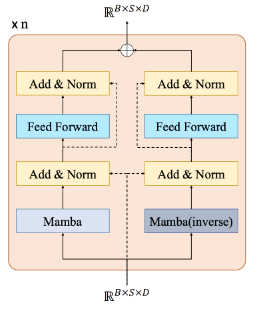

**Code inspiration :**

* https://github.com/hustvl/Vim
* https://github.com/state-spaces/mamba/blob/main/mamba_ssm/models/mixer_seq_simple.py
* https://huggingface.co/JunxiongWang/MambaByte_Arxiv
* https://huggingface.co/docs/transformers/main/en/tasks/image_captioning (Pokemon dataset)


In [45]:
!pip install -q mamba-ssm causal-conv1d

In [1]:
import torch, math
import skimage as sk
import numpy as np, pylab as plt
from torch import nn
import torch.nn.functional as F
from numpy.lib.stride_tricks import as_strided
from dataclasses import dataclass
import cv2
from datasets import load_dataset
from skimage import io, transform, color, img_as_ubyte
from mamba_ssm.modules.mamba_simple import Mamba

ModuleNotFoundError: No module named 'mamba_ssm'

In [2]:
def input_seq_construct(arr, dim=3, sep_val=255):
    if dim % 2 == 0 : dim +=1
    pw = (dim-1)//2
    # Padding around array and size
    padded_arr = np.pad(arr, pad_width=pw, mode='constant', constant_values=0)
    shape = (arr.shape[0], arr.shape[1], dim, dim)
    strides = padded_arr.strides * 2  # double step
    # Data matrix construct
    matrix_dxd = as_strided(padded_arr, shape=shape, strides=strides)
    # include time asymetry (need correction for dim!=3)
    result = np.copy(matrix_dxd).astype(np.uint8)
    result[:, :, pw:, -pw:] = 0
    result[:, :, -pw, :] = 0
    # if image data, including skip line
    if shape[0] > 1 :
        separator = np.zeros((shape[0], 1, dim, dim), dtype=np.uint8)
        separator[:, 0, 1, 1] = sep_val
        result = np.concatenate((result, separator), axis=1)
        # Linearize
        return result.reshape(-1, dim, dim)[:-1][None]
    else :
        return result.reshape(-1, dim, dim)[None]

@dataclass
class MambaConfig:
    dim: int # The input dimension of the input tensor.
    d_state: int = 16 #16 # The dimension of the state space model.
    d_conv : int = 4 # The convolutionnal windows
    expand: int = 2 # E in paper/comments
    depth : int = 8 # The number of residual S6 layers
    vocab_size : int = 256+216+2 # ASCII bytes + RGB 6*6*6 pixel + img step/stop

class BysMamba(nn.Module):
    def __init__(self, config: MambaConfig):
        super().__init__()
        self.config = config
        # text & image(t) embedding
        self.linear_embedding = nn.Embedding(config.vocab_size, config.dim)
        self.patch_embedding = nn.Conv2d(in_channels=config.dim, out_channels=config.dim, kernel_size=3, stride=1, padding=0) # 3D in future
        # mamba part
        self.in_mamba = Mamba(d_model=config.dim, d_state=config.d_state, d_conv=config.d_conv, expand=config.expand,)
        self.layers = nn.ModuleList([Mamba(d_model=config.dim, d_state=config.d_state, d_conv=config.d_conv, expand=config.expand,) for _ in range(config.depth)])
        self.out_mamba = Mamba(d_model=config.dim, d_state=config.d_state, d_conv=config.d_conv, expand=config.expand,)
        # output
        self.lm_head = nn.Linear(config.dim, config.vocab_size, bias=False)

    def forward(self, x):
        # shape : x : (B, L, M=3, N=3) : long
        B,L,M,N = x.shape
        dim = self.config.dim
        # embedding
        x = self.linear_embedding(x.view(B*L, M, N)).squeeze()
        x = x.permute(0, 3, 1, 2)  # (batch_size*L, embedding_dim, height, width)
        x = ((x[:,:,M//2,N//2].squeeze() + self.patch_embedding(x)).view(B, L, dim))/2 # (B,L,D)
        # bidirectional mamba input
        x += (self.in_mamba(x) + self.in_mamba(torch.flip(x, dims=[1])).flip([1]))/2
        # mamba intermediate layers
        for layer in self.layers:
            x += layer(x)
        # bidirectional mamba output
        x += (self.out_mamba(x) + self.out_mamba(torch.flip(x, dims=[1])).flip([1]))/2
        # prediction output
        x = self.lm_head(x) # probability
        return x

In [4]:
# "Tokenizer"
Pixelbytes =  {
                0 : b'\x00',
                1 : b'\t',
                2 : b'\n',
                3 : b' ',
                4 : b'"',
                5 : b"'",
                6 : b'(',
                7 : b')',
                8 : b'*',
                9 : b',',
                10 : b'-',
                11 : b'.',
                12 : b'0',
                13 : b'1',
                14 : b'2',
                15 : b'3',
                16 : b'4',
                17 : b'5',
                18 : b'6',
                19 : b'7',
                20 : b'8',
                21 : b'9',
                22 : b'B',
                23 : b'C',
                24 : b'D',
                25 : b'E',
                26 : b'F',
                27 : b'I',
                28 : b'P',
                29 : b'R',
                30 : b'T',
                31 : b'W',
                32 : b'Z',
                33 : b'a',
                34 : b'b',
                35 : b'c',
                36 : b'd',
                37 : b'e',
                38 : b'f',
                39 : b'g',
                40 : b'h',
                41 : b'i',
                42 : b'j',
                43 : b'k',
                44 : b'l',
                45 : b'm',
                46 : b'n',
                47 : b'o',
                48 : b'p',
                49 : b'q',
                50 : b'r',
                51 : b's',
                52 : b't',
                53 : b'u',
                54 : b'v',
                55 : b'w',
                56 : b'x',
                57 : b'y',
                58 : b'z',
                59 : [0x00, 0x00, 0x00],
                60 : [0xfc, 0xfc, 0xfc],
                61 : [0xf8, 0xf8, 0xf8],
                62 : [0xbc, 0xbc, 0xbc],
                63 : [0x7c, 0x7c, 0x7c],
                64 : [0xa4, 0xe4, 0xfc],
                65 : [0x3c, 0xbc, 0xfc],
                66 : [0x00, 0x78, 0xf8],
                67 : [0x00, 0x00, 0xfc],
                68 : [0xb8, 0xb8, 0xf8],
                69 : [0x68, 0x88, 0xfc],
                70 : [0x00, 0x58, 0xf8],
                71 : [0x00, 0x00, 0xbc],
                72 : [0xd8, 0xb8, 0xf8],
                73 : [0x98, 0x78, 0xf8],
                74 : [0x68, 0x44, 0xfc],
                75 : [0x44, 0x28, 0xbc],
                76 : [0xf8, 0xb8, 0xf8],
                77 : [0xf8, 0x78, 0xf8],
                78 : [0xd8, 0x00, 0xcc],
                79 : [0x94, 0x00, 0x84],
                80 : [0xf8, 0xa4, 0xc0],
                81 : [0xf8, 0x58, 0x98],
                82 : [0xe4, 0x00, 0x58],
                83 : [0xa8, 0x00, 0x20],
                84 : [0xf0, 0xd0, 0xb0],
                85 : [0xf8, 0x78, 0x58],
                86 : [0xf8, 0x38, 0x00],
                87 : [0xa8, 0x10, 0x00],
                88 : [0xfc, 0xe0, 0xa8],
                89 : [0xfc, 0xa0, 0x44],
                90 : [0xe4, 0x5c, 0x10],
                91 : [0x88, 0x14, 0x00],
                92 : [0xf8, 0xd8, 0x78],
                93 : [0xf8, 0xb8, 0x00],
                94 : [0xac, 0x7c, 0x00],
                95 : [0x50, 0x30, 0x00],
                96 : [0xd8, 0xf8, 0x78],
                97 : [0xb8, 0xf8, 0x18],
                98 : [0x00, 0xb8, 0x00],
                99 : [0x00, 0x78, 0x00],
                100 : [0xb8, 0xf8, 0xb8],
                101 : [0x58, 0xd8, 0x54],
                102 : [0x00, 0xa8, 0x00],
                103 : [0x00, 0x68, 0x00],
                104 : [0xb8, 0xf8, 0xd8],
                105 : [0x58, 0xf8, 0x98],
                106 : [0x00, 0xa8, 0x44],
                107 : [0x00, 0x58, 0x00],
                108 : [0x00, 0xfc, 0xfc],
                109 : [0x00, 0xe8, 0xd8],
                110 : [0x00, 0x88, 0x88],
                111 : [0x00, 0x40, 0x58],
                112 : [0xf8, 0xd8, 0xf8],
                113 : [0x78, 0x78, 0x78],}

In [5]:
# Palette NES personnalisée
palette = np.array([
    [0x00, 0x00, 0x00], [0xfc, 0xfc, 0xfc], [0xf8, 0xf8, 0xf8], [0xbc, 0xbc, 0xbc],
    [0x7c, 0x7c, 0x7c], [0xa4, 0xe4, 0xfc], [0x3c, 0xbc, 0xfc], [0x00, 0x78, 0xf8],
    [0x00, 0x00, 0xfc], [0xb8, 0xb8, 0xf8], [0x68, 0x88, 0xfc], [0x00, 0x58, 0xf8],
    [0x00, 0x00, 0xbc], [0xd8, 0xb8, 0xf8], [0x98, 0x78, 0xf8], [0x68, 0x44, 0xfc],
    [0x44, 0x28, 0xbc], [0xf8, 0xb8, 0xf8], [0xf8, 0x78, 0xf8], [0xd8, 0x00, 0xcc],
    [0x94, 0x00, 0x84], [0xf8, 0xa4, 0xc0], [0xf8, 0x58, 0x98], [0xe4, 0x00, 0x58],
    [0xa8, 0x00, 0x20], [0xf0, 0xd0, 0xb0], [0xf8, 0x78, 0x58], [0xf8, 0x38, 0x00],
    [0xa8, 0x10, 0x00], [0xfc, 0xe0, 0xa8], [0xfc, 0xa0, 0x44], [0xe4, 0x5c, 0x10],
    [0x88, 0x14, 0x00], [0xf8, 0xd8, 0x78], [0xf8, 0xb8, 0x00], [0xac, 0x7c, 0x00],
    [0x50, 0x30, 0x00], [0xd8, 0xf8, 0x78], [0xb8, 0xf8, 0x18], [0x00, 0xb8, 0x00],
    [0x00, 0x78, 0x00], [0xb8, 0xf8, 0xb8], [0x58, 0xd8, 0x54], [0x00, 0xa8, 0x00],
    [0x00, 0x68, 0x00], [0xb8, 0xf8, 0xd8], [0x58, 0xf8, 0x98], [0x00, 0xa8, 0x44],
    [0x00, 0x58, 0x00], [0x00, 0xfc, 0xfc], [0x00, 0xe8, 0xd8], [0x00, 0x88, 0x88],
    [0x00, 0x40, 0x58], [0xf8, 0xd8, 0xf8], [0x78, 0x78, 0x78]
], dtype=np.uint8)

def image_pixelization(img, palette, max_size=20): 
    num_colors = len(palette)
    ## Cropping part
    # Binarize image
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    _, binary = cv2.threshold(gray, 240, 255, cv2.THRESH_BINARY_INV)
    # Find Rectangle
    contours, _ = cv2.findContours(binary, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    x, y, w, h = cv2.boundingRect(max(contours, key=cv2.contourArea))
    # Crop image
    x_min, y_min = max(0, x), max(0, y)
    x_max, y_max = min(img.shape[1], x + w), min(img.shape[0], y + h)
    img = img[y_min:y_max, x_min:x_max]
    ## Pretreatment
    # Remove alpha (if)
    if img.shape[2] == 4:
        rgb_channels = img[:, :, :3]
        alpha_channel = img[:, :, 3] / 255.0
        # Merge image with white background
        white_background = np.ones_like(rgb_channels, dtype=np.uint8) * 255
        img = cv2.convertScaleAbs(rgb_channels * alpha_channel[..., None] + white_background * (1 - alpha_channel[..., None]))
    # Scale factor calculation
    h, w = img.shape[:2]
    scale_factor = max_size / max(h, w)
    # resizing
    new_height = int(min(h,w) * scale_factor)
    img = cv2.resize(img, (2*new_height, 2*max_size) if h>w else (2*max_size, 2*new_height), interpolation=cv2.INTER_NEAREST)
    ## Quantize image
    # Flatten image and convertion
    img = cv2.cvtColor(img, cv2.COLOR_BGR2Lab)
    pixels = img.reshape((-1, 3))
    pixels = np.float32(pixels)
    # K-Means Clustering
    criteria = (cv2.TERM_CRITERIA_EPS + cv2.TERM_CRITERIA_MAX_ITER, 100, 0.2)
    _, labels, centers = cv2.kmeans(pixels, num_colors, None, criteria, 10, cv2.KMEANS_RANDOM_CENTERS)
    # Change pixel following cluster
    centers = np.uint8(centers)
    quantized = centers[labels.flatten()]
    img = cv2.cvtColor(quantized.reshape(img.shape), cv2.COLOR_Lab2BGR)
    # resizing
    new_height = int(min(h,w) * scale_factor)
    img = cv2.resize(img, (new_height, max_size) if h>w else (max_size, new_height), interpolation=cv2.INTER_NEAREST)
    ## Palette association
    palette_rgb = palette.copy()
    palette = color.rgb2lab(palette_rgb.reshape(1, -1, 3) / 255.0).reshape(-1, 3)
    def closest_color(pixel, palette):
        pixel_lab = color.rgb2lab(pixel.reshape(1, 1, 3) / 255.0).reshape(3)
        # distance
        distances = np.linalg.norm(palette - pixel_lab, axis=1)
        # Retourner la couleur la plus proche en RGB
        return palette_rgb[np.argmin(distances)]
    img = np.apply_along_axis(closest_color, 2 , img, palette)
    return img

In [16]:
ds = load_dataset("reach-vb/pokemon-blip-captions") #load_dataset("tungdop2/pokemon") #
train_ds = ds["train"]
ds

DatasetDict({
    train: Dataset({
        features: ['image', 'text'],
        num_rows: 833
    })
})

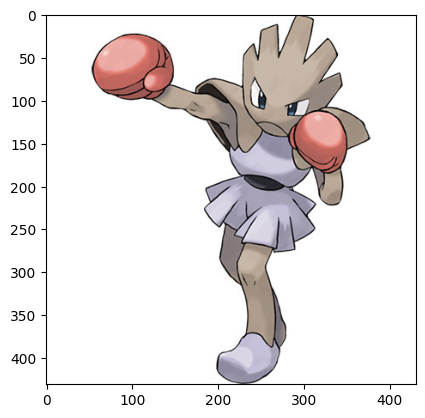

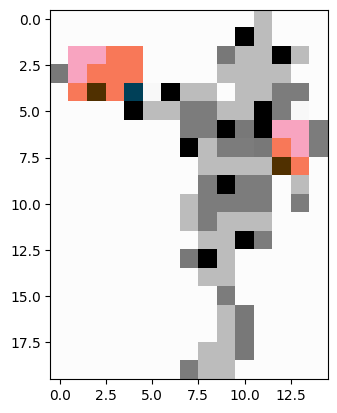

300.0
a drawing of a girl with a boxing glove 39


In [24]:
n = 9
pkmn = np.array(train_ds[n]["image"])
quantized_pkmn = image_pixelization(pkmn, palette, max_size=20)
plt.imshow(pkmn);plt.show()
plt.imshow(quantized_pkmn);plt.show()
print(quantized_pkmn.size/3)
#caption = train_ds[n]["caption"]
caption = train_ds[n]["text"]
#name = train_ds[n]["name"]
print(caption, len(caption))

In [51]:
Pixelbytes_reverse = {tuple(v): k for k, v in Pixelbytes.items()}
# Fonction vectorisée pour appliquer le mapping
vectorized_map = np.vectorize(lambda x,y,z: Pixelbytes_reverse.get((int(x), int(y), int(z)), None))
# Séparer les canaux RGB
r, g, b = quantized_pkmn[..., 0], quantized_pkmn[..., 1], quantized_pkmn[..., 2]
# Appliquer la fonction vectorisée
pixelv_pkmn = vectorized_map(r, g, b)
print(pixelv_pkmn.shape, '\n', pixelv_pkmn)

(20, 15) 
 [[ 60  60  60  60  60  60  60  60  60  60  60  62  60  60  60]
 [ 60  60  60  60  60  60  60  60  60  60  59  62  60  60  60]
 [ 60  80  80  85  85  60  60  60  60 113  62  62  59  62  60]
 [113  80  85  85  85  60  60  60  60  62  62  62  62  60  60]
 [ 60  85  95  85 111  61  59  62  62  60  62  62  63  63  60]
 [ 60  60  60  60  59  62  62  63  63  62  62  59  63  61  60]
 [ 60  60  60  60  60  60  60  63  63  59 113  59  80  80  63]
 [ 60  60  60  60  60  60  60  59  62  63  63 113  85  80  63]
 [ 60  60  60  60  60  60  60  60  62  62  62  62  95  85  60]
 [ 60  60  60  60  60  60  60  60  63  59  63  63  60  62  60]
 [ 60  60  60  60  60  60  60  62  63  63  63  63  60  63  60]
 [ 60  60  60  60  60  60  60  62  63  62  62  62  60  60  60]
 [ 60  60  60  60  60  60  60  60  62  62  59  63  60  60  60]
 [ 60  60  60  60  60  60  60 113  59  62  60  60  60  60  60]
 [ 60  60  60  60  60  60  60  60  62  62  60  60  60  60  60]
 [ 60  60  60  60  60  60  60  60  60  63  6

In [65]:
Pixelbytes_reverse

{(0,): 0,
 (9,): 1,
 (10,): 2,
 (32,): 3,
 (34,): 4,
 (39,): 5,
 (40,): 6,
 (41,): 7,
 (42,): 8,
 (44,): 9,
 (45,): 10,
 (46,): 11,
 (48,): 12,
 (49,): 13,
 (50,): 14,
 (51,): 15,
 (52,): 16,
 (53,): 17,
 (54,): 18,
 (55,): 19,
 (56,): 20,
 (57,): 21,
 (66,): 22,
 (67,): 23,
 (68,): 24,
 (69,): 25,
 (70,): 26,
 (73,): 27,
 (80,): 28,
 (82,): 29,
 (84,): 30,
 (87,): 31,
 (90,): 32,
 (97,): 33,
 (98,): 34,
 (99,): 35,
 (100,): 36,
 (101,): 37,
 (102,): 38,
 (103,): 39,
 (104,): 40,
 (105,): 41,
 (106,): 42,
 (107,): 43,
 (108,): 44,
 (109,): 45,
 (110,): 46,
 (111,): 47,
 (112,): 48,
 (113,): 49,
 (114,): 50,
 (115,): 51,
 (116,): 52,
 (117,): 53,
 (118,): 54,
 (119,): 55,
 (120,): 56,
 (121,): 57,
 (122,): 58,
 (0, 0, 0): 59,
 (252, 252, 252): 60,
 (248, 248, 248): 61,
 (188, 188, 188): 62,
 (124, 124, 124): 63,
 (164, 228, 252): 64,
 (60, 188, 252): 65,
 (0, 120, 248): 66,
 (0, 0, 252): 67,
 (184, 184, 248): 68,
 (104, 136, 252): 69,
 (0, 88, 248): 70,
 (0, 0, 188): 71,
 (216, 184, 248

In [83]:
 Pixelbytes_reverse.get((97, None), 97)

97

In [81]:
# Convertir le texte en bytes
bytes_list = list(caption.encode('utf-8'))
# Appliquer la fonction vectorisée
bytesv_pkmn = [Pixelbytes_reverse[(x, None)] for x in bytes_list]
bytesv_pkmn

KeyError: (97, None)

In [54]:
bytes('a drawing of a girl with a boxing glove')

TypeError: string argument without an encoding

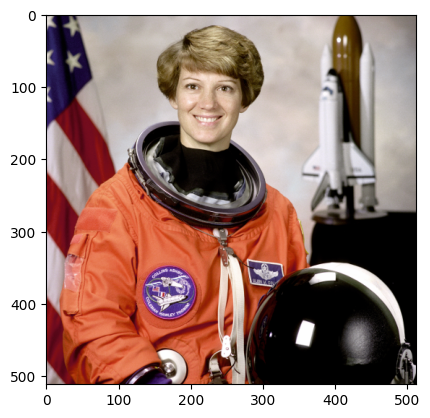

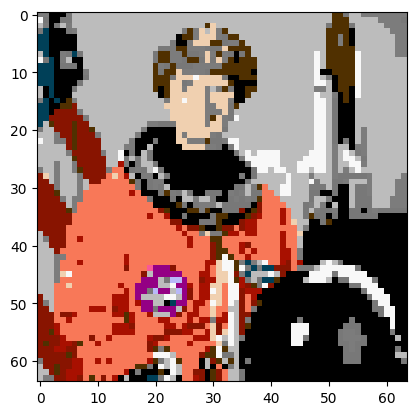

In [23]:
image = sk.data.astronaut()
quant_img = image_pixelization(image,palette, max_size=64)
plt.imshow(image);plt.show()
plt.imshow(quant_img);plt.show()

In [48]:
d_model, d_state, n_layers = 64, 16, 8
config = MambaConfig(dim=d_model, d_state=d_state, depth=n_layers)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
# import model
model = BysMamba(config).to(device)

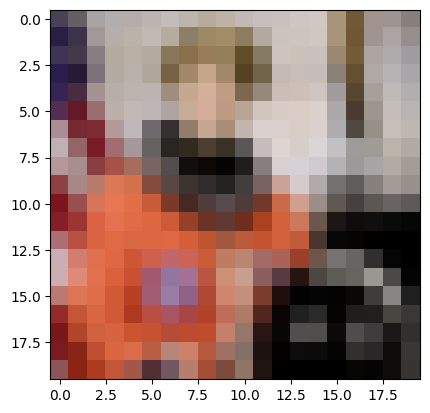

In [77]:
image = sk.data.astronaut()
quant_img = Color_rquantization(image)
plt.imshow(Color_rquantization(image, return_resize=True));plt.show()

In [49]:
img_seq = input_seq_construct(quant_img, dim=3)#[:,-d_model:,]
img_seq.shape

(1, 419, 3, 3)

In [50]:
input_ids = torch.from_numpy(img_seq).long().to(device)
B, L, M, N = input_ids.shape
print(B, L, M, N)

In [51]:
logits = model(input_ids)
print(logits.shape, logits.min(), logits.max())

In [52]:
## add generate
sample: bool = True
top_k: int = None
temperature: float = 1.0

next_token_logits = logits[:, -1]
with torch.no_grad():
    if sample:
        probs = F.softmax(next_token_logits / temperature, dim=-1)
        next_token = torch.multinomial(probs, num_samples=1)
    else:
        next_token = next_token_logits.argmax(dim=-1, keepdim=True)

print(next_token.squeeze())

In [56]:
#from huggingface_hub import notebook_login

#notebook_login()
#!huggingface-cli login

In [4]:
ds = load_dataset("reach-vb/pokemon-blip-captions")#"lambdalabs/pokemon-blip-captions")
ds

Generating train split:   0%|          | 0/833 [00:00<?, ? examples/s]

DatasetDict({
    train: Dataset({
        features: ['image', 'text'],
        num_rows: 833
    })
})

In [25]:
ds = load_dataset("tungdop2/pokemon") # mieux
ds

Generating train split:   0%|          | 0/1271 [00:00<?, ? examples/s]

DatasetDict({
    train: Dataset({
        features: ['image', 'name', 'type_1', 'type_2', 'caption'],
        num_rows: 1271
    })
})

In [26]:
#ds = ds["train"]#.train_test_split(test_size=0.1)
train_ds = ds["train"]
#test_ds = ds["test"]

In [156]:
character_list = np.unique(sorted(" ".join(train_ds["caption"])))
print(character_list, len(character_list))

[' ' '"' "'" ',' '-' '.' 'B' 'C' 'D' 'E' 'F' 'I' 'P' 'R' 'T' 'W' 'Z' 'a'
 'b' 'c' 'd' 'e' 'f' 'g' 'h' 'i' 'j' 'k' 'l' 'm' 'n' 'o' 'p' 'q' 'r' 's'
 't' 'u' 'v' 'w' 'x' 'y' 'z'] 43


In [17]:
print([p.hex() for p in Pixelbytes])

['00', '09', '0a', '20', '22', '27', '28', '29', '2a', '2c', '2d', '2e', '30', '31', '32', '33', '34', '35', '36', '37', '38', '39', '42', '43', '44', '45', '46', '49', '50', '52', '54', '57', '5a', '61', '62', '63', '64', '65', '66', '67', '68', '69', '6a', '6b', '6c', '6d', '6e', '6f', '70', '71', '72', '73', '74', '75', '76', '77', '78', '79', '7a']


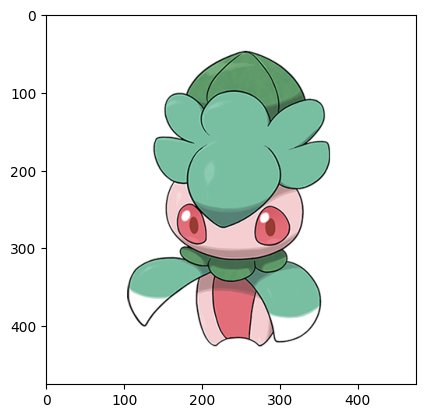

In [134]:
n = 1
pkmn = np.array(train_ds[n]["image"])
caption = train_ds[n]["caption"]
name = train_ds[n]["name"]
#caption = train_ds[n]["text"]
plt.imshow(pkmn); plt.show()

In [136]:
caption = train_ds[n]["caption"]
name = train_ds[n]["name"]
print(name, caption, len(caption))

fomantis a green creature with a pink face, wearing a green hat and a pink scarf. 72


In [137]:
import cv2

def auto_crop(image, padding=2):
    # Convertir l'image en niveaux de gris
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    # Binariser l'image (tout ce qui n'est pas blanc devient noir)
    _, binary = cv2.threshold(gray, 240, 255, cv2.THRESH_BINARY_INV)
    # Trouver les contours de l'objet
    contours, _ = cv2.findContours(binary, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    if not contours: return image  # Retourner l'image originale si aucun contour n'est trouvé
    # Trouver le rectangle englobant
    x, y, w, h = cv2.boundingRect(max(contours, key=cv2.contourArea))
    # Ajouter le padding
    x_min, y_min = max(0, x - padding), max(0, y - padding)
    x_max, y_max = min(image.shape[1], x + w + padding), min(image.shape[0], y + h + padding)
    # Recadrer l'image
    cropped = image[y_min:y_max, x_min:x_max]
    return cropped

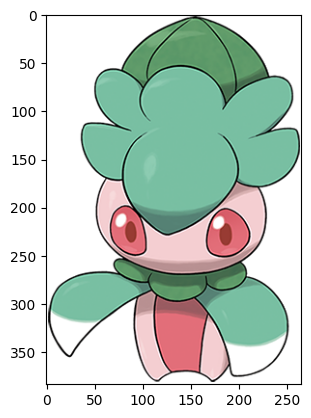

In [138]:
crop = auto_crop(pkmn)
plt.imshow(crop);plt.show()

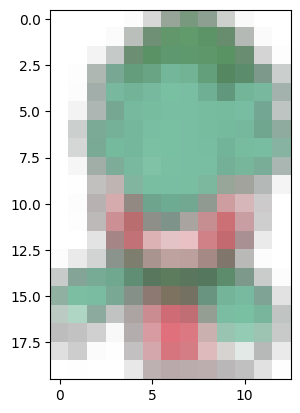

In [139]:
pixel_pkmn = Color_rquantization(crop, max_size=20, return_resize=True)
plt.imshow(pixel_pkmn); plt.show() ## NOT GOOD

In [129]:
def create_pixel_art(img, pixel_size=15, num_colors=55):
    if img.shape[2] == 4:
        # Séparer les canaux RGB et Alpha
        rgb_channels = img[:, :, :3]
        alpha_channel = img[:, :, 3] / 255.0

        # Créer un arrière-plan blanc
        white_background = np.ones_like(rgb_channels, dtype=np.uint8) * 255

        # Mélanger l'image avec le fond blanc selon le canal alpha
        img = cv2.convertScaleAbs(rgb_channels * alpha_channel[..., None] + white_background * (1 - alpha_channel[..., None]))
    # Redimensionner l'image
    height, width = img.shape[:2]
    small = cv2.resize(img, (width // pixel_size, height // pixel_size), interpolation=cv2.INTER_NEAREST) #INTER_LINEAR)
    
    # Convertir en Lab pour un meilleur regroupement des couleurs
    small_lab = cv2.cvtColor(small, cv2.COLOR_BGR2Lab)
    
    # Aplatir l'image pour le clustering
    pixels = small_lab.reshape((-1, 3))
    
    # Convertir en float32
    pixels = np.float32(pixels)
    
    # Définir les critères de clustering
    criteria = (cv2.TERM_CRITERIA_EPS + cv2.TERM_CRITERIA_MAX_ITER, 100, 0.2)
    
    # Appliquer le clustering K-means
    _, labels, centers = cv2.kmeans(pixels, num_colors, None, criteria, 10, cv2.KMEANS_RANDOM_CENTERS)
    
    # Convertir les centres en uint8
    centers = np.uint8(centers)
    
    # Remplacer chaque pixel par sa couleur correspondante dans la palette
    quantized = centers[labels.flatten()]
    
    # Reformer l'imagesmall
    quantized = quantized.reshape(small.shape)
    
    # Convertir de Lab à BGR
    quantized = cv2.cvtColor(quantized, cv2.COLOR_Lab2BGR)
    
    return quantized
    # Agrandir l'image pour voir les pixels
    pixel_art = cv2.resize(quantized, (width, height), interpolation=cv2.INTER_NEAREST)
    
    return pixel_art

(25, 17, 3)

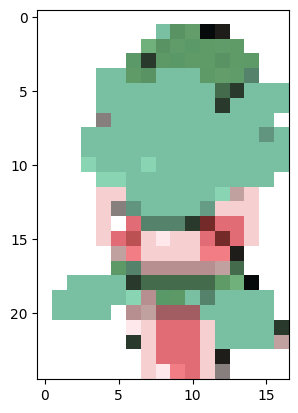

In [140]:
pixel_art = create_pixel_art(crop)
plt.imshow(pixel_art)
pixel_art.shape

https://en.wikipedia.org/wiki/List_of_video_game_console_palettes

In [71]:
def plot_rect_color(rgb):
    """Convertit un triplet RGB en code couleur hexadécimal."""
    color = '#{:02x}{:02x}{:02x}'.format(*rgb)
    fig, ax = plt.subplots(figsize=(1, 1))
    ax.add_patch(plt.Rectangle((0, 0), 1, 1, color=color)) #palette[np.argmin(distances)]
    plt.show()

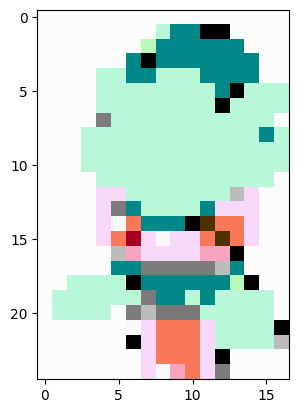

In [141]:

# Palette NES personnalisée
palette_rgb = np.array([
    [0x00, 0x00, 0x00], [0xfc, 0xfc, 0xfc], [0xf8, 0xf8, 0xf8], [0xbc, 0xbc, 0xbc],
    [0x7c, 0x7c, 0x7c], [0xa4, 0xe4, 0xfc], [0x3c, 0xbc, 0xfc], [0x00, 0x78, 0xf8],
    [0x00, 0x00, 0xfc], [0xb8, 0xb8, 0xf8], [0x68, 0x88, 0xfc], [0x00, 0x58, 0xf8],
    [0x00, 0x00, 0xbc], [0xd8, 0xb8, 0xf8], [0x98, 0x78, 0xf8], [0x68, 0x44, 0xfc],
    [0x44, 0x28, 0xbc], [0xf8, 0xb8, 0xf8], [0xf8, 0x78, 0xf8], [0xd8, 0x00, 0xcc],
    [0x94, 0x00, 0x84], [0xf8, 0xa4, 0xc0], [0xf8, 0x58, 0x98], [0xe4, 0x00, 0x58],
    [0xa8, 0x00, 0x20], [0xf0, 0xd0, 0xb0], [0xf8, 0x78, 0x58], [0xf8, 0x38, 0x00],
    [0xa8, 0x10, 0x00], [0xfc, 0xe0, 0xa8], [0xfc, 0xa0, 0x44], [0xe4, 0x5c, 0x10],
    [0x88, 0x14, 0x00], [0xf8, 0xd8, 0x78], [0xf8, 0xb8, 0x00], [0xac, 0x7c, 0x00],
    [0x50, 0x30, 0x00], [0xd8, 0xf8, 0x78], [0xb8, 0xf8, 0x18], [0x00, 0xb8, 0x00],
    [0x00, 0x78, 0x00], [0xb8, 0xf8, 0xb8], [0x58, 0xd8, 0x54], [0x00, 0xa8, 0x00],
    [0x00, 0x68, 0x00], [0xb8, 0xf8, 0xd8], [0x58, 0xf8, 0x98], [0x00, 0xa8, 0x44],
    [0x00, 0x58, 0x00], [0x00, 0xfc, 0xfc], [0x00, 0xe8, 0xd8], [0x00, 0x88, 0x88],
    [0x00, 0x40, 0x58], [0xf8, 0xd8, 0xf8], [0x78, 0x78, 0x78]
], dtype=np.uint8)

# Convertir la palette en espace Lab
palette_lab = color.rgb2lab(palette_rgb.reshape(1, -1, 3) / 255.0).reshape(-1, 3)

def closest_color_lab(pixel, palette_lab):
    # Convertir le pixel en espace Lab
    pixel_lab = color.rgb2lab(pixel.reshape(1, 1, 3) / 255.0).reshape(3)
    # Calculer la distance euclidienne dans l'espace Lab
    distances = np.linalg.norm(palette_lab - pixel_lab, axis=1)
    # Retourner la couleur la plus proche en RGB
    return palette_rgb[np.argmin(distances)]

def apply_palette(image, palette):
    quantized_image = np.apply_along_axis(closest_color_lab, 2 , image, palette)
    return quantized_image

# Appliquer la palette
quantized_image = apply_palette(pixel_art, palette_lab)
plt.imshow(quantized_image);plt.show()

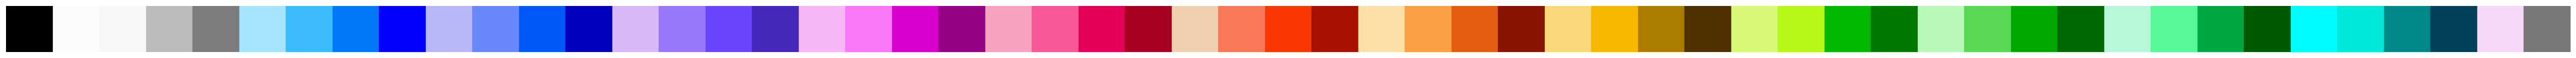

In [20]:
def convertir_rgb_en_hex(rgb):
    """Convertit un triplet RGB en code couleur hexadécimal."""
    return '#{:02x}{:02x}{:02x}'.format(*rgb)

def afficher_palette(couleurs_rgb):
    # Convertit chaque couleur RGB en code hexadécimal
    couleurs_hex = [convertir_rgb_en_hex(couleur) for couleur in couleurs_rgb]
    
    # Crée une figure et un axe
    fig, ax = plt.subplots(figsize=(len(couleurs_hex), 1))
    
    # Supprime les axes
    ax.set_axis_off()
    
    # Affiche les couleurs sous forme de rectangles
    for i, couleur in enumerate(couleurs_hex):
        ax.add_patch(plt.Rectangle((i, 0), 1, 1, color=couleur))
    
    # Ajuste les limites de l'axe
    ax.set_xlim(0, len(couleurs_hex))
    ax.set_ylim(0, 1)
    
    # Affiche la palette
    plt.show()

# Appelle la fonction pour afficher la palette
afficher_palette(palette)

https://perplexity.ai/search/nintendo-entertainment-system-ZLvs9l_BS2C2We5Sd6HIpg

---

# UNIT TEST MODEL CONSTRUCT PART

---

In [6]:
dim : int = 64 # The input dimension of the input tensor.
d_state : int = 16 #16 # The dimension of the state space model.
d_conv : int = 4 # The convolutionnal windows
expand: int = 2 # E in paper/comments
depth : int = 8 # The number of residual S6 layers

d_model = dim
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [38]:
# text & image(t) embedding
vocab_size = 256+216+2 # ASCII bytes + RGB 6*6*6 pixel + img step/stop + coherent to mamba dim matmul ??
linear_embedding = nn.Embedding(256+512, d_model).to(device) # 256 for ASCII text and 512 for image
#patch_embedding = nn.Conv2d(in_channels=1, out_channels=vocab_size, kernel_size=3, stride=1, padding=0).to(device) # 3D in future
patch_embedding = nn.Conv2d(in_channels=d_model, out_channels=d_model, kernel_size=3, stride=1, padding=0).to(device) # 3D in future
# mamba part
#mamba = Mamba(d_model=dim, d_state=d_state, d_conv=d_conv, expand=expand,)
lm_head = nn.Linear(dim, vocab_size, bias=False).to(device)

## Classic text embedding

In [8]:
# bytes([i for i in range(16**3)].decode('utf-8') # doesn't work, max 256
#text = "\documentclass[12pt]{article}"
#text_byte = np.frombuffer(text.encode('utf-8'), dtype=np.uint8)
# text bytes test
s = [chr(i) for i in range(16**2)]
#text_byte = np.frombuffer("".join(s).encode('utf-8'), dtype=np.uint8)
text_byte = np.arange(256, dtype=np.uint8)
text_byte.shape

(256,)

In [15]:
input_ids = torch.from_numpy(text_byte[None, :]).long().to(device)
x = linear_embedding(input_ids)
print(x,'\n\n',x.shape)

tensor([[[ 1.2264,  1.7725, -0.5454,  ..., -0.4184,  0.4222,  1.9495],
         [ 0.7210,  1.0705, -0.4412,  ..., -1.1305, -0.5248,  1.3291],
         [-0.7159, -0.1346,  1.1338,  ...,  1.4293, -1.3619,  0.5763],
         ...,
         [-0.9637,  0.4218,  1.1491,  ...,  0.3976, -0.0506,  2.0163],
         [-1.0375,  0.6577, -1.1778,  ...,  0.0267,  0.3278,  0.2518],
         [ 0.8056,  1.1221, -2.4802,  ...,  1.0334, -0.0599, -0.4942]]],
       grad_fn=<EmbeddingBackward0>) 

 torch.Size([1, 256, 64])


## Conv2d image-text embedding

In [27]:
image = sk.data.astronaut()
quant_img = Color_rquantization(image)
img_seq = input_seq_construct(quant_img, dim=3)
img_seq = torch.from_numpy(img_seq).long().to(device)
img_seq.shape

torch.Size([1, 419, 3, 3])

In [31]:
B,L,M,N = img_seq.shape
# no_batch
img_seqb = img_seqb.view(B*L, M, N)
img_seqb.shape

torch.Size([419, 3, 3])

In [34]:
x = linear_embedding(img_seq)[0]
x.shape

torch.Size([419, 3, 3, 64])

In [36]:
embedded = x.permute(0, 3, 1, 2)  # (batch_size, embedding_dim, height, width)
embedded.shape

torch.Size([419, 64, 3, 3])

In [42]:
x = patch_embedding(embedded).squeeze()
x.shape

torch.Size([419, 64])

In [44]:
x.view(B, L, d_model)

tensor([[[ 0.5695, -0.5125,  0.0360,  ..., -0.5090, -0.3664,  0.6227],
         [-0.1077, -0.8013, -0.3885,  ...,  0.1050, -0.6146,  1.1521],
         [ 0.0544, -0.9053,  0.0264,  ...,  0.0729, -0.5495,  0.8696],
         ...,
         [ 0.2683,  0.2798, -0.3743,  ..., -0.6645, -0.8665,  0.0613],
         [ 0.3154,  0.0698, -0.0796,  ..., -0.7941, -0.5592,  0.2135],
         [ 0.4411,  0.1930, -0.5962,  ..., -0.8457, -0.2633,  0.9977]]],
       grad_fn=<ViewBackward0>)

In [50]:
# for inference show (need to create)
def colors_216_to_rgb(img):
    # Convertir les valeurs de 0-215 en RGB
    r = (img // 36) * 51
    g = ((img % 36) // 6) * 51
    b = (img % 6) * 51
    # Combiner les canaux RGB
    return np.stack([r, g, b], axis=-1).astype(np.uint8)

In [ ]:
def Color_rquantization(img, max_size=20, nb_colors=216, return_resize = False):
    # Scale factor calculation
    m, n, _ = img.shape
    scale_factor = max_size / max(m,n) # image.shape[1] # to update to calculate max beetween L or l
    # Resize image
    new_height = int(min(m,n) * scale_factor) #     new_height = int(image.shape[0] * scale_factor)
    # Resize (use opencv in futur ? cv2.resize(img, (w,h), interpolation=cv2.INTER_NEAREST)
    if n>m : resized_image  = transform.resize(img, (new_height, max_size), anti_aliasing=True)
    else : resized_image  = transform.resize(img, (max_size, new_height), anti_aliasing=True)
    ## Construct palette
    img = img_as_ubyte(resized_image)
    if return_resize : return resized_image
    # cubic root numerotation 
    c = np.rint(np.cbrt(nb_colors)).astype(int)
    # reduce to x level per channel
    img_x = np.rint(img/(255/(c-1))).astype(np.uint8)
    # Convertir image 0 to nb_colors
    img_c = img_x[:, :, 0] * c**2 + img_x[:, :, 1] * c + img_x[:, :, 2]
    # Convertir en image 8 bits
    return img_c.astype(np.uint8)